## Initial data preprocess

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('output.csv')
df.head()

,Unnamed: 0,Year,Age,Female,Male,Total
0,1,1922,0,0.070053,0.092574,0.081500
1,2,1922,1,0.024976,0.027255,0.026130
2,3,1922,2,0.012143,0.012979,0.012566
3,4,1922,3,0.006072,0.006324,0.006199
4,5,1922,4,0.004426,0.004305,0.004365


In [3]:
column_classes = df.dtypes
print(column_classes)

Unnamed: 0     int64
Year           int64
Age           object
Female        object
Male          object
Total         object
dtype: object


In [4]:
df = df[~((df['Female'] == '.') | (df['Male'] == '.') | (df['Total'] == '.'))]

In [5]:
# change the data type
df['Female'] = df['Female'].astype(float)
df['Male'] = df['Male'].astype(float)
df['Total'] = df['Total'].astype(float)
df['Age'] = df['Age'].str.replace('+', '',regex=False).astype(int)

In [6]:
column_classes = df.dtypes
print(column_classes)

Unnamed: 0      int64
Year            int64
Age             int64
Female        float64
Male          float64
Total         float64
dtype: object


In [10]:
# check the age that has the missing value
value_cn = df['Age'].value_counts()
value_cn[value_cn < 99]

105    93
106    83
107    64
108    49
109    43
110    26
Name: Age, dtype: int64

In [11]:
# remove those age
df = df[(df['Age'] != 105) & (df['Age'] != 106) & (df['Age'] != 107) & (df['Age'] != 108) & (df['Age'] != 109) & (df['Age'] != 110)]

In [12]:
# using the assumption between m(t,x) and q(t,x) to generate q(t,x)
import numpy as np
df['Female_q'] = 1-np.exp(-df['Female'])
df['Male_q'] = 1-np.exp(-df['Male'])
df['Total_q'] = 1- np.exp(-df['Total'])

In [13]:
# logit function
def compute_logit(probability):
    return np.log(probability / (1 - probability))

In [14]:
# compute the logit q(t,x)
epsilon = 1e-20
df['Female_log'] =compute_logit(df['Female_q']+epsilon)
df['Male_log'] = compute_logit(df['Male_q']+epsilon)
df['Total_log'] = compute_logit(df['Total_q']+epsilon)

In [16]:
# calculate the mean age
mean_value = df['Age'].mean()
print("The mean age is :",mean_value)

The mean age is : 52.0


## Parameter estimation (SVD)

### Female

In [17]:
fm_params = {}
for year in range(1922,2021):
    data_year = df[df['Year'] == year]
    n = len(data_year)
    matrix = np.array([[1]*n, (data_year['Age']-mean_value).tolist()]).T
    U, S, V = np.linalg.svd(matrix, full_matrices=False)
    y = data_year["Female_log"]
    params = V.T @ np.diag(1/S) @ U.T @ y
    fm_params[year] = params  

In [18]:
fm_params = pd.DataFrame.from_dict(fm_params, orient='index', columns=['k1', 'k2']).reset_index()
fm_params.columns = ['Year','K1','K2']

In [89]:
fm_params

,Year,K1,K2
0,1922,-3.795659,0.058101
1,1923,-3.897522,0.058892
2,1924,-3.846497,0.059434
3,1925,-3.855206,0.059806
4,1926,-3.910063,0.060074
...,...,...,...
94,2016,-5.614725,0.089971
95,2017,-5.637287,0.090838
96,2018,-5.623028,0.090336
97,2019,-5.645507,0.089570


### Male

In [20]:
m_params = {}
for year in range(1922,2021):
    data_year = df[df['Year'] == year]
    n = len(data_year)
    matrix = np.array([[1]*n, (data_year['Age']-mean_value).tolist()]).T
    U, S, V = np.linalg.svd(matrix, full_matrices=False)
    y = data_year["Male_log"]
    params = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y
    m_params[year] = params 
    
m_params = pd.DataFrame.from_dict(m_params, orient='index', columns=['k1', 'k2']).reset_index()
m_params.columns = ['Year','K1','K2']

In [21]:
m_params

,Year,K1,K2
0,1922,-3.649543,0.058782
1,1923,-3.711477,0.060702
2,1924,-3.676468,0.060773
3,1925,-4.127788,0.035962
4,1926,-3.725258,0.061679
...,...,...,...
94,2016,-5.208599,0.088208
95,2017,-5.219971,0.088197
96,2018,-5.200147,0.087722
97,2019,-5.251218,0.087743


### Total

In [22]:
t_params = {}
for year in range(1922,2021):
    data_year = df[df['Year'] == year]
    n = len(data_year)
    matrix = np.array([[1]*n, (data_year['Age']-mean_value).tolist()]).T
    U, S, V = np.linalg.svd(matrix, full_matrices=False)
    y = data_year["Total_log"]
    params = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y
    t_params[year] = params 
    
t_params = pd.DataFrame.from_dict(t_params, orient='index', columns=['k1', 'k2']).reset_index()
t_params.columns = ['Year','K1','K2']

In [23]:
t_params

,Year,K1,K2
0,1922,-3.724782,0.058427
1,1923,-3.814474,0.059363
2,1924,-3.769654,0.059733
3,1925,-3.779151,0.059990
4,1926,-3.825288,0.060573
...,...,...,...
94,2016,-5.399513,0.088107
95,2017,-5.412246,0.088625
96,2018,-5.394322,0.087986
97,2019,-5.431147,0.087844


## boot-strap 5 sample training data

In [24]:
# Train set
split_index_fm = int(len(fm_params) * 0.8)
split_index_m = int(len(m_params) * 0.8)
split_index_t = int(len(t_params) * 0.8)

fm = fm_params[:split_index_fm]
m = m_params[:split_index_m]
t = t_params[:split_index_t]

split_index_fm_v = int(len(fm) * 0.8)
split_index_m_v = int(len(m) * 0.8)
split_index_t_v = int(len(t) * 0.8)

train_fm = fm[:split_index_fm_v]
train_m = m[:split_index_m_v]
train_t = t[:split_index_t_v]

# Validation set
valid_fm = fm[split_index_fm_v:]
valid_m = m[split_index_m_v:]
valid_t = t[split_index_t_v:]

# Test set
test_fm = fm_params[split_index_fm:]
test_m = m_params[split_index_m:]
test_t = t_params[split_index_t:]

In [25]:
from sklearn.preprocessing import StandardScaler
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(train_fm['K2'].values.reshape(-1, 1))
X_train_scaled = scaler.transform(train_fm['K2'].values.reshape(-1, 1))

scaler.fit(train_m['K2'].values.reshape(-1, 1))
X_train_scaled_m = scaler.transform(train_m['K2'].values.reshape(-1, 1))

scaler.fit(train_t['K2'].values.reshape(-1, 1))
X_train_scaled_t = scaler.transform(train_t['K2'].values.reshape(-1, 1))

### death rate estimation

In [72]:
rest_data = df[df['Year']>=1985]

In [178]:
ages = np.arange(0, 105)

# Function to calculate m(t,x) given the value of K1, K2 and age
def calculate_y(K1, K2, ages):
    return -np.log(1 - (np.exp(K1 + K2 * (ages - 52))) / (1 + (np.exp(K1 + K2 * (ages - 52)))))

# Create a list to store the intermediate DataFrames
result_dfs = []

# Calculate m(t,x) for each age and year combination using a loop
for index, row in train_fm.iterrows():
    result_df = pd.DataFrame()
    result_df['Year'] = [row['Year']] * len(ages)
    result_df['Age'] = ages
    result_df['Female'] = calculate_y(row['K1'], row['K2'], ages)
    result_dfs.append(result_df)

# Female m(t,x) estimation
result_fm = pd.concat(result_dfs, ignore_index=True)

In [179]:
# Create a list to store the intermediate DataFrames
result_dfs = []

# Calculate m(t,x) for each age and year combination using a loop
for index, row in train_m.iterrows():
    result_df = pd.DataFrame()
    result_df['Year'] = [row['Year']] * len(ages)
    result_df['Age'] = ages
    result_df['Male'] = calculate_y(row['K1'], row['K2'], ages)
    result_dfs.append(result_df)

# Male m(t,x) estimation
result_m = pd.concat(result_dfs, ignore_index=True)

In [180]:
# Create a list to store the intermediate DataFrames
result_dfs = []

# Calculate m(t,x) for each age and year combination using a loop
for index, row in train_t.iterrows():
    result_df = pd.DataFrame()
    result_df['Year'] = [row['Year']] * len(ages)
    result_df['Age'] = ages
    result_df['Total'] = calculate_y(row['K1'], row['K2'], ages)
    result_dfs.append(result_df)

# Total m(t,x) estimation
result_t = pd.concat(result_dfs, ignore_index=True)

### deviance residual for exponential distribution

In [228]:
train_org = df[df['Year']<= 1984]

In [229]:
train_org = train_org.reset_index(drop=True)

In [231]:
# calculate the devaince residual
sqrt_fm = 2 * (1 - train_org['Female'] / result_fm['Female'] + np.log(result_fm['Female'] / train_org['Female']))
sqrt_m = 2 * (1 - train_org['Male'] / result_m['Male'] + np.log(result_m['Male'] / train_org['Male']))
sqrt_t = 2 * (1 - train_org['Total'] / result_t['Total'] + np.log(result_t['Total'] / train_org['Total']))

sqrt_ng_fm = np.clip(sqrt_fm, a_min=0, a_max=None)
sqrt_ng_m = np.clip(sqrt_m, a_min=0, a_max=None)
sqrt_ng_t = np.clip(sqrt_t, a_min=0, a_max=None)

fm_d = np.where(sqrt_fm >= 0,
                np.sign(train_org['Female'] - result_fm['Female']) * np.sqrt(sqrt_ng_fm),
                np.nan
               )
m_d = np.where(sqrt_m >= 0,
                np.sign(train_org['Male'] - result_m['Male']) * np.sqrt(sqrt_ng_m),
                np.nan
               )
t_d = np.where(sqrt_t >= 0,
                np.sign(train_org['Total'] - result_t['Total']) * np.sqrt(sqrt_ng_t),
                np.nan
               )

In [245]:
nan_mask = np.isnan(fm_d)
fm_d = fm_d[~nan_mask]

nan_mask_m = np.isnan(m_d)
m_d = m_d[~nan_mask_m]

nan_mask_t = np.isnan(t_d)
t_d = t_d[~nan_mask_t]

In [328]:
mask = np.isinf(m_d)
m_d = m_d[~mask]

### bootstrap

In [349]:
# Perform bootstrap sampling with replacement
fm_bs = np.random.choice(fm_d, size=(5, len(result_fm)), replace=True)
m_bs = np.random.choice(m_d, size=(5, len(result_m)), replace=True)
t_bs = np.random.choice(t_d, size=(5, len(result_t)), replace=True)

### re-estimate the death rate

In [350]:
# implementation of the Newton-Raphson method
def f(x, m, r):
    return 2 * (1- m/x + np.log(x/m)) - r**2

def df(x, m):
    return 2 * ( m / x**2 + 1/x)

def newton_raphson(m, r, initial_guess, max_iterations=100, tolerance=1e-8):
    x_n = initial_guess
    for i in range(max_iterations):
        if m == 0:
            m = 1e-8
        f_x_n = f(x_n, m, r)
        df_x_n = df(x_n, m)

        x_n_plus_1 = x_n - f_x_n / df_x_n
        if x_n_plus_1 <= 0:
            x_n_plus_1 = 1e-8

        if abs(x_n_plus_1 - x_n) < tolerance:
            break

        x_n = x_n_plus_1

    return x_n

In [357]:
# re-estimate death rate for female
solutions_fm = []
for r in fm_bs:
    current_solutions = []
    for r_value, m in zip(r, train_org['Female']):
        initial_guess = 0.1  # You can choose any appropriate initial guess
        solution = newton_raphson(m, r_value, initial_guess)
        current_solutions.append(solution)
    solutions_fm.append(current_solutions)

In [358]:
# re-estimate death rate for male
solutions_m = []
for r in m_bs:
    current_solutions = []
    for r_value, m in zip(r, train_org['Male']):
        initial_guess = 0.1  # You can choose any appropriate initial guess
        solution = newton_raphson(m, r_value, initial_guess)
        current_solutions.append(solution)
    solutions_m.append(current_solutions)

In [359]:
# re-estimate death rate for Total
solutions_t = []
for r in t_bs:
    current_solutions = []
    for r_value, m in zip(r, train_org['Total']):
        initial_guess = 0.1  # You can choose any appropriate initial guess
        solution = newton_raphson(m, r_value, initial_guess)
        current_solutions.append(solution)
    solutions_t.append(current_solutions)

### create the death rate data

In [364]:
df_fm = pd.DataFrame(solutions_fm)
df_fm = df_fm.transpose()

In [367]:
df_fm['Year']=train_org['Year']

In [369]:
df_fm['Age']=train_org['Age']

In [372]:
df_m = pd.DataFrame(solutions_m)
df_m = df_m.transpose()
df_m['Year']=train_org['Year']
df_m['Age']=train_org['Age']

In [373]:
df_t = pd.DataFrame(solutions_t)
df_t = df_t.transpose()
df_t['Year']=train_org['Year']
df_t['Age']=train_org['Age']

In [375]:
df_fm.to_csv('fm_sample.csv', index=False)
df_m.to_csv('m_sample.csv', index=False)
df_t.to_csv('t_sample.csv', index=False)

### create sample data of k2 (use SVD)

In [380]:
epsilon = 1e-20
df_fm['0_log'] = compute_logit(1-np.exp(-df_fm[0])+epsilon)
df_fm['1_log'] = compute_logit(1-np.exp(-df_fm[1])+epsilon)
df_fm['2_log'] = compute_logit(1-np.exp(-df_fm[2])+epsilon)
df_fm['3_log'] = compute_logit(1-np.exp(-df_fm[3])+epsilon)
df_fm['4_log'] = compute_logit(1-np.exp(-df_fm[4])+epsilon)

In [382]:
df_m['0_log'] = compute_logit(1-np.exp(-df_m[0])+epsilon)
df_m['1_log'] = compute_logit(1-np.exp(-df_m[1])+epsilon)
df_m['2_log'] = compute_logit(1-np.exp(-df_m[2])+epsilon)
df_m['3_log'] = compute_logit(1-np.exp(-df_m[3])+epsilon)
df_m['4_log'] = compute_logit(1-np.exp(-df_m[4])+epsilon)

In [383]:
df_t['0_log'] = compute_logit(1-np.exp(-df_t[0])+epsilon)
df_t['1_log'] = compute_logit(1-np.exp(-df_t[1])+epsilon)
df_t['2_log'] = compute_logit(1-np.exp(-df_t[2])+epsilon)
df_t['3_log'] = compute_logit(1-np.exp(-df_t[3])+epsilon)
df_t['4_log'] = compute_logit(1-np.exp(-df_t[4])+epsilon)

In [384]:
fm_params_1 = {}
fm_params_2 = {}
fm_params_3 = {}
fm_params_4 = {}
fm_params_5 = {}
for year in range(1922,1985):
    data_year = df_fm[df_fm['Year'] == year]
    n = len(data_year)
    matrix = np.array([[1]*n, (data_year['Age']-mean_value).tolist()]).T
    U, S, V = np.linalg.svd(matrix, full_matrices=False)
    
    y1 = data_year["0_log"]
    y2 = data_year["1_log"]
    y3 = data_year["2_log"]
    y4 = data_year["3_log"]
    y5 = data_year["4_log"]
    
    params1 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y1
    params2 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y2
    params3 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y3
    params4 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y4
    params5 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y5
   
    fm_params_1[year] = params1
    fm_params_2[year] = params2
    fm_params_3[year] = params3
    fm_params_4[year] = params4
    fm_params_5[year] = params5
    
fm_params_1 = pd.DataFrame.from_dict(fm_params_1, orient='index', columns=['k1', 'k2']).reset_index()
fm_params_1.columns = ['Year','K1','K2']

fm_params_2 = pd.DataFrame.from_dict(fm_params_2, orient='index', columns=['k1', 'k2']).reset_index()
fm_params_2.columns = ['Year','K1','K2']

fm_params_3 = pd.DataFrame.from_dict(fm_params_3, orient='index', columns=['k1', 'k2']).reset_index()
fm_params_3.columns = ['Year','K1','K2']

fm_params_4 = pd.DataFrame.from_dict(fm_params_4, orient='index', columns=['k1', 'k2']).reset_index()
fm_params_4.columns = ['Year','K1','K2']

fm_params_5 = pd.DataFrame.from_dict(fm_params_5, orient='index', columns=['k1', 'k2']).reset_index()
fm_params_5.columns = ['Year','K1','K2']

In [401]:
m_params_1 = {}
m_params_2 = {}
m_params_3 = {}
m_params_4 = {}
m_params_5 = {}
for year in range(1922,1985):
    data_year = df_m[df_m['Year'] == year]
    n = len(data_year)
    matrix = np.array([[1]*n, (data_year['Age']-mean_value).tolist()]).T
    U, S, V = np.linalg.svd(matrix, full_matrices=False)
    
    y1 = data_year["0_log"]
    y2 = data_year["1_log"]
    y3 = data_year["2_log"]
    y4 = data_year["3_log"]
    y5 = data_year["4_log"]
    
    params1 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y1
    params2 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y2
    params3 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y3
    params4 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y4
    params5 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y5
   
    m_params_1[year] = params1
    m_params_2[year] = params2
    m_params_3[year] = params3
    m_params_4[year] = params4
    m_params_5[year] = params5
    
m_params_1 = pd.DataFrame.from_dict(m_params_1, orient='index', columns=['k1', 'k2']).reset_index()
m_params_1.columns = ['Year','K1','K2']

m_params_2 = pd.DataFrame.from_dict(m_params_2, orient='index', columns=['k1', 'k2']).reset_index()
m_params_2.columns = ['Year','K1','K2']

m_params_3 = pd.DataFrame.from_dict(m_params_3, orient='index', columns=['k1', 'k2']).reset_index()
m_params_3.columns = ['Year','K1','K2']

m_params_4 = pd.DataFrame.from_dict(m_params_4, orient='index', columns=['k1', 'k2']).reset_index()
m_params_4.columns = ['Year','K1','K2']

m_params_5 = pd.DataFrame.from_dict(m_params_5, orient='index', columns=['k1', 'k2']).reset_index()
m_params_5.columns = ['Year','K1','K2']

In [390]:
t_params_1 = {}
t_params_2 = {}
t_params_3 = {}
t_params_4 = {}
t_params_5 = {}
for year in range(1922,1985):
    data_year = df_t[df_t['Year'] == year]
    n = len(data_year)
    matrix = np.array([[1]*n, (data_year['Age']-mean_value).tolist()]).T
    U, S, V = np.linalg.svd(matrix, full_matrices=False)
    
    y1 = data_year["0_log"]
    y2 = data_year["1_log"]
    y3 = data_year["2_log"]
    y4 = data_year["3_log"]
    y5 = data_year["4_log"]
    
    params1 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y1
    params2 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y2
    params3 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y3
    params4 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y4
    params5 = V.T @ np.linalg.inv(np.diag(S)) @ U.T @ y5
   
    t_params_1[year] = params1
    t_params_2[year] = params2
    t_params_3[year] = params3
    t_params_4[year] = params4
    t_params_5[year] = params5
    
t_params_1 = pd.DataFrame.from_dict(t_params_1, orient='index', columns=['k1', 'k2']).reset_index()
t_params_1.columns = ['Year','K1','K2']

t_params_2 = pd.DataFrame.from_dict(t_params_2, orient='index', columns=['k1', 'k2']).reset_index()
t_params_2.columns = ['Year','K1','K2']

t_params_3 = pd.DataFrame.from_dict(t_params_3, orient='index', columns=['k1', 'k2']).reset_index()
t_params_3.columns = ['Year','K1','K2']

t_params_4 = pd.DataFrame.from_dict(t_params_4, orient='index', columns=['k1', 'k2']).reset_index()
t_params_4.columns = ['Year','K1','K2']

t_params_5 = pd.DataFrame.from_dict(t_params_5, orient='index', columns=['k1', 'k2']).reset_index()
t_params_5.columns = ['Year','K1','K2']

In [393]:
rest_data_fm = fm_params[fm_params['Year']>1984]
rest_data_m = m_params[m_params['Year']>1984]
rest_data_t = t_params[t_params['Year']>1984]

In [394]:
fm_params_1 = pd.concat([fm_params_1, rest_data_fm])

In [397]:
fm_params_2 = pd.concat([fm_params_2, rest_data_fm])
fm_params_3 = pd.concat([fm_params_3, rest_data_fm])
fm_params_4 = pd.concat([fm_params_4, rest_data_fm])
fm_params_5 = pd.concat([fm_params_5, rest_data_fm])

In [402]:
m_params_1 = pd.concat([m_params_1, rest_data_m])
m_params_2 = pd.concat([m_params_2, rest_data_m])
m_params_3 = pd.concat([m_params_3, rest_data_m])
m_params_4 = pd.concat([m_params_4, rest_data_m])
m_params_5 = pd.concat([m_params_5, rest_data_m])

In [405]:
t_params_1 = pd.concat([t_params_1, rest_data_t])
t_params_2 = pd.concat([t_params_2, rest_data_t])
t_params_3 = pd.concat([t_params_3, rest_data_t])
t_params_4 = pd.concat([t_params_4, rest_data_t])
t_params_5 = pd.concat([t_params_5, rest_data_t])

In [408]:
fm_params_1.to_csv('fm_params_1.csv', index=False)
fm_params_2.to_csv('fm_params_2.csv', index=False)
fm_params_3.to_csv('fm_params_3.csv', index=False)
fm_params_4.to_csv('fm_params_4.csv', index=False)
fm_params_5.to_csv('fm_params_5.csv', index=False)

m_params_1.to_csv('m_params_1.csv', index=False)
m_params_2.to_csv('m_params_2.csv', index=False)
m_params_3.to_csv('m_params_3.csv', index=False)
m_params_4.to_csv('m_params_4.csv', index=False)
m_params_5.to_csv('m_params_5.csv', index=False)

t_params_1.to_csv('t_params_1.csv', index=False)
t_params_2.to_csv('t_params_2.csv', index=False)
t_params_3.to_csv('t_params_3.csv', index=False)
t_params_4.to_csv('t_params_4.csv', index=False)
t_params_5.to_csv('t_params_5.csv', index=False)

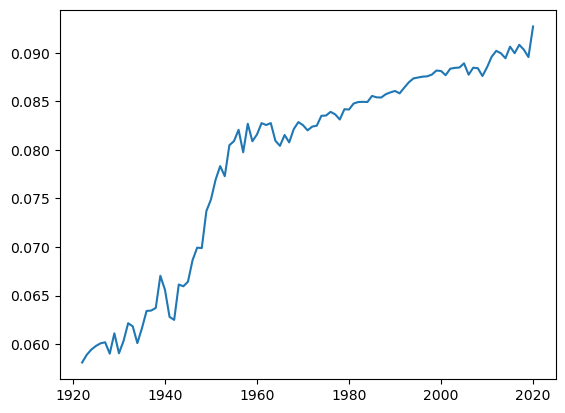

In [411]:
import matplotlib.pyplot as plt
plt.plot(fm_params['Year'], fm_params['K2'])
plt.show()

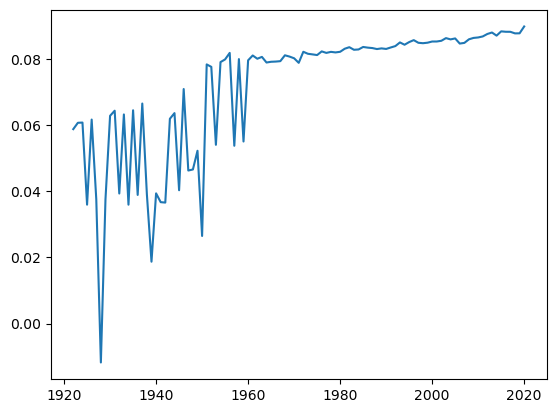

In [434]:
plt.plot(m_params['Year'], m_params['K2'])
plt.show()

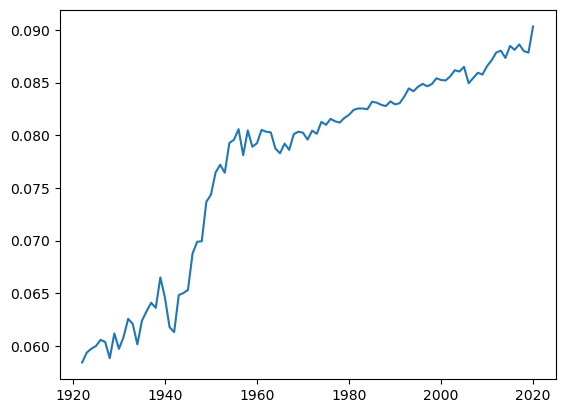

In [433]:
plt.plot(t_params['Year'], t_params['K2'])
plt.show()

The data is non stationary 

## ARIMA

### Dataset split

In [26]:
#Traing set
split_index_fm = int(len(fm_params) * 0.8)
split_index_m = int(len(m_params) * 0.8)
split_index_t = int(len(t_params) * 0.8)

train_fm = fm_params[:split_index_fm]
train_m = m_params[:split_index_m]
train_t = t_params[:split_index_t]

#Testing set
test_fm = fm_params[split_index_fm:]
test_m = m_params[split_index_m:]
test_t = t_params[split_index_t:]

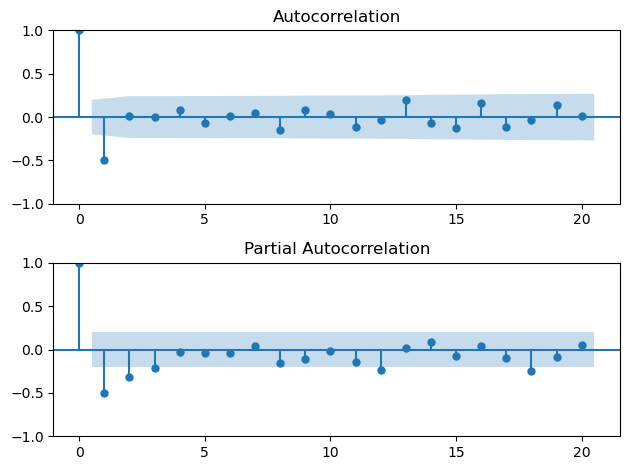

In [34]:
#Female
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(fm_params['K2_diff'][1:],lags=20, ax=ax[0])
plot_pacf(fm_params['K2_diff'][1:],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

For Female, the possible model could be ARIMA(0,1,1)

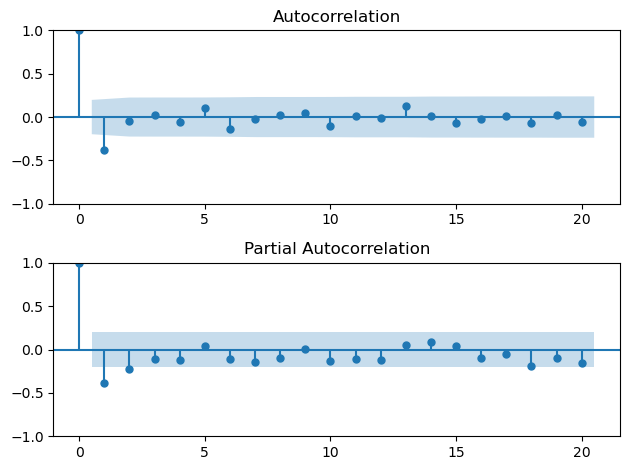

In [37]:
#Male
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(m_params['K2_diff'][1:],lags=20, ax=ax[0])
plot_pacf(m_params['K2_diff'][1:],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

For male, the possible model could be ARIMA(0,1,1)

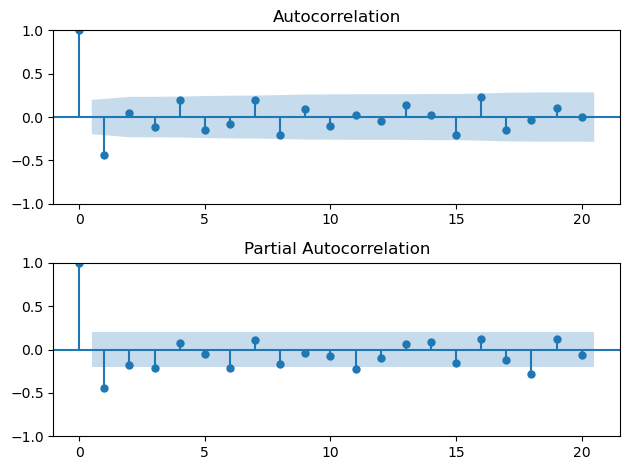

In [38]:
#Total
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(t_params['K2_diff'][1:],lags=20, ax=ax[0])
plot_pacf(t_params['K2_diff'][1:],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

For total, the possible model could be ARIMA(0,1,1)

## Auto fit

In [70]:
# auto-fit for female
import pmdarima as pm
from sklearn.preprocessing import StandardScaler
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(train_fm['K2'].values.reshape(-1, 1))
X_train_scaled = scaler.transform(train_fm['K2'].values.reshape(-1, 1))

auto_fm = pm.auto_arima(X_train_scaled, stepwise=False, seasonal=False)
auto_fm

/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal


ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

In [78]:
# auto-fit for male
scaler.fit(train_m['K2'].values.reshape(-1, 1))
X_train_scaled_m = scaler.transform(train_m['K2'].values.reshape(-1, 1))

auto_m = pm.auto_arima(X_train_scaled_m, stepwise=False, seasonal=False)
auto_m

/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [81]:
# auto-fit for total
scaler.fit(train_t['K2'].values.reshape(-1, 1))
X_train_scaled_t = scaler.transform(train_t['K2'].values.reshape(-1, 1))

auto_t = pm.auto_arima(X_train_scaled_t, stepwise=False, seasonal=False)
auto_t

/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

### generate the ARIMA prediction and prediction interval

In [63]:
# Female
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(X_train_scaled, order=(2,1,3))
model_fit = model.fit()
predict = model_fit.get_forecast(steps=len(test_fm))
confidence_intervals = predict.conf_int(0.05)
forecast_fm = model_fit.forecast(steps=len(test_fm))

In [65]:
# Male
model_m = ARIMA(X_train_scaled_m, order=(0,1,1))
model_fit_m = model_m.fit()
predict_m = model_fit_m.get_forecast(steps=len(test_m))
confidence_intervals_m = predict_m.conf_int(0.05)
forecast_m = model_fit.forecast(steps=len(test_m))

In [67]:
# Total
model_t = ARIMA(X_train_scaled_t, order=(0,1,1))
model_fit_t = model_t.fit()
predict_t = model_fit_t.get_forecast(steps=len(test_t))
confidence_intervals_t = predict_t.conf_int(0.05)
forecast_t = model_fit.forecast(steps=len(test_t))

/Users/mingzeluan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
# transform the output to original scale
forecast_fm_in = scaler.inverse_transform(forecast_fm.reshape(-1, 1))

In [76]:
fm_lower, fm_upper = zip(*confidence_intervals)
fm_lower = np.array(fm_lower)
fm_upper = np.array(fm_upper)

In [77]:
fm_lower_in = scaler.inverse_transform(fm_lower.reshape(-1, 1))
fm_upper_in = scaler.inverse_transform(fm_upper.reshape(-1, 1))

In [79]:
forecast_m_in = scaler.inverse_transform(forecast_m.reshape(-1, 1))

In [80]:
m_lower, m_upper = zip(*confidence_intervals_m)
m_lower = np.array(m_lower)
m_upper = np.array(m_upper)
m_lower_in = scaler.inverse_transform(m_lower.reshape(-1, 1))
m_upper_in = scaler.inverse_transform(m_upper.reshape(-1, 1))

In [82]:
forecast_t_in = scaler.inverse_transform(forecast_t.reshape(-1, 1))

In [83]:
t_lower, t_upper = zip(*confidence_intervals_t)
t_lower = np.array(t_lower)
t_upper = np.array(t_upper)
t_lower_in = scaler.inverse_transform(t_lower.reshape(-1, 1))
t_upper_in = scaler.inverse_transform(t_upper.reshape(-1, 1))

In [87]:
#ARIMA_csv = pd.DataFrame(forecast_fm_in, columns = ['Female'])
ARIMA_csv['Male'] = forecast_m_in
ARIMA_csv['Total'] = forecast_t_in
ARIMA_csv['Female_l'] = fm_lower_in
ARIMA_csv['Female_u'] = fm_upper_in
ARIMA_csv['Male_l'] = m_lower_in
ARIMA_csv['Male_u'] = m_upper_in
ARIMA_csv['Total_l'] = t_lower_in
ARIMA_csv['Total_u'] = t_upper_in

In [88]:
ARIMA_csv.to_csv('ARIMA.csv', index=False)

### Save the data

In [410]:
fm_params.to_csv('fm_params.csv', index=False)
m_params.to_csv('m_params.csv', index=False)
t_params.to_csv('t_params.csv', index=False)